In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage, stats
from sklearn.metrics import classification_report, confusion_matrix

from operator import itemgetter
import pickle as pkl
from itertools import groupby
from collections import defaultdict

import keras
from keras import regularizers
from keras.datasets import mnist
from keras.layers import Dense, Flatten, Convolution2D, Conv2D, Dropout, MaxPooling2D, BatchNormalization, GaussianNoise, Activation
from keras.models import Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.constraints import max_norm
from keras.optimizers import Adam

from PIL import Image, ImageDraw, ImageFont
import os
import datetime

In [2]:
def read_im(filename,sigma=5):
    img = cv2.imread(filename,0)
    return ndimage.gaussian_filter(img, sigma=sigma)

def threshold_im(img):
    kernel = np.ones((50,50),np.uint8)

    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    ret,th1 = cv2.threshold(img,130,255,cv2.THRESH_BINARY)

    return th1


def plot_im(img):
    plt.imshow(img,'gray')
    plt.xticks([]),plt.yticks([])
    plt.show()
    
def get_rectangles_in_order(rectangles):
    assert len(rectangles == 16)
    r = rectangles
    r = sorted(r,key=itemgetter(0))
    new_r = []
    for idx in range(0,15,4):
        new_r.extend(sorted(r[idx:idx+4],key=itemgetter(1)))
    return new_r

def is_rectangle_overlap(rect1,rect2):
    x1,y1,w1,h1 = rect1
    x2,y2,w2,h2 = rect2
    
    l1 = (x1,y1)
    r1 = (x1+w1,y1-h1)
    l2 = (x2,y2)
    r2 = (x2+w2, y2-h2)
    
    if (l1[0] > r2[0] or l2[0] > r1[0]):
#         print("c1")
        return False
    
    if (l1[1] < r2[1] or l2[1] < r1[1]):
#         print("c2")
        return False
    
    return True

def get_bounding_rectangles(thresh):
    contours, hier = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    extent_fxn = lambda c,w,h: cv2.contourArea(c)/(w*h)
    area_fxn = lambda rect: float(rect[2])*rect[3]
    contourList = []
    
    # get rid of areas that are above 2 standard deviations from mean
    sorted_contours = sorted(contours, key = cv2.contourArea, reverse = True)
    sorted_counters = sorted_contours[:min(25,len(sorted_contours))]
    contour_areas = [cv2.contourArea(cnt) for cnt in sorted_contours]
    outlier = abs(stats.zscore(contour_areas))>=2
    sorted_contours = [x for idx,x in enumerate(sorted_contours) if outlier[idx] == False]
    
    # go through contours, get bounded rectangle and decide whether it can be a tile or not
    for idx,cnt in enumerate(sorted_contours):
        epsilon = 0.05*cv2.arcLength(cnt,True)
        app = cv2.approxPolyDP(cnt,epsilon,True)
        (x,y,w,h) = cv2.boundingRect(app)
        if len(app) >= 4 and extent_fxn(cnt,w,h) > 0.2 and len(contourList) < 16:
            contourList.append((x,y,w,h))
            
    # sanity check: are there rectangles with an overlap? 
    # might be a rectangle within a rectangle, so get rid of it
    keep_rect = [True]*len(contourList)
    for i,rect1 in enumerate(contourList[:]):
        for j,rect2 in enumerate(contourList[:]):
            if i != j and is_rectangle_overlap(rect1,rect2):
                keep_rect[max(i,j)] = False # since contourList is sorted by area, least area is the largest index
           
    r = [cnt for idx,cnt in enumerate(contourList) if keep_rect[idx] == True]
    
    # sort by grid order
    r = sorted(r,key=itemgetter(0))
    new_r = []
    for idx in range(0,15,4):
        new_r.extend(sorted(r[idx:idx+4],key=itemgetter(1)))
        
    # todo: if countourList is less than 16, try to guesstimate the missing coordinates??
    return new_r
    
def load_data(fn):
    d = np.load(fn,allow_pickle=True)
    # d = data['data']
    d = {key:d[key].item() for key in d}
    data = d['data']
    return data, dict(zip(sorted(data.keys()),range(0,26)))

def threshold_letter(img):
    ret,th1 = cv2.threshold(img,60,255,cv2.THRESH_BINARY)
    return th1


def create_dataset(data,N,img_x,img_y,labels,modify=True):
    img_per_letter = int(N/len(data.keys()))
    x = np.zeros((N,img_x,img_y),dtype='uint8')
    y = np.zeros(N,dtype='uint8')
#     labels = dict(zip(data.keys(),range(0,len(data.keys()))))
    print(labels)
    current_N = 0
    for letter, images in data.items():
        chosen_idx = np.random.randint(0,len(images),size=(img_per_letter))
        images = [cv2.resize(im,(img_x,img_y),interpolation=cv2.INTER_AREA) for im in images]
        if modify:
            for idx,chosen in enumerate(chosen_idx):
                x[current_N+idx] = speckle(images[chosen],p=np.random.uniform(0.,0.2))
                y[current_N+idx] = labels[letter]
            current_N=current_N+idx+1
        else:
#             for idx in range(0,len(images)):
            for idx,chosen in enumerate(chosen_idx):
                x[current_N+idx] = images[chosen]
                y[current_N+idx] = labels[letter]
            current_N=current_N+idx+1
    return x,y

def process_rectangle(letter_bb):
    letter_bb = threshold_letter(letter_bb)
    return letter_bb

def create_white_bg():
    img = np.zeros([img_x,img_y,3],dtype=np.uint8)
    img.fill(255)
    cv2_im_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    pil_im = Image.fromarray(cv2_im_rgb)
    return pil_im

def gen_image(letter,qu_font,normal_font):
    pil_im = create_white_bg()
    draw = ImageDraw.Draw(pil_im)
    if letter == 'QU':
        letter = 'Qu'
        font = qu_font
        wq,hq = font.getsize(letter[0])
        wu,hu = font.getsize(letter[1])
        w = wq+wu
        h = hq+hu
    else:
        font = normal_font
        w,h = font.getsize(letter)

    x_loc,y_loc = (np.random.randint(0,img_x-w), np.random.randint(0,img_y-h))
#     x_loc, y_loc = (5,5)
    draw.text((x_loc,y_loc),letter, font=font,fill='black') 
    return pil_im

def generate_dataset_v2(img_x, img_y, N, labels):
    normal_font = ImageFont.truetype("EUROSTILE.ttf", 25)
    qu_font = ImageFont.truetype("EUROSTILE.ttf", 16)
    chosen_letters = np.random.choice(list(labels.keys()), size=(1,N))

    
    y = np.zeros(N,dtype='uint8')
    for idx,letter in enumerate(chosen_letters[0]):
        pil_im = gen_image(letter,qu_font,normal_font)
        cv2_im_processed = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2GRAY)
        x[idx] = speckle(cv2_im_processed,p=np.random.uniform(0.,0.2))
        y[idx] = labels[letter]
#         plt.imshow(x[idx],'gray')
#         plt.show()
    return x,y

def get_border_indices(img_x,img_y,th):
    a = np.arange(0,img_x*img_y).reshape((img_x,img_y))
    return np.concatenate((np.ravel(a[:,0:th]),np.ravel(a[0:th,:]),\
                           np.ravel(a[:,img_y-th:img_y]),np.ravel(a[img_x-th:img_x,:])),axis=0)

def speckle(img,p=0.3,th=2):
    img_x,img_y = img.shape
    border_idx = get_border_indices(img_x,img_y,th)
    num_elements = np.round(p*border_idx.shape[0]).astype(int)
    severity = np.random.choice(border_idx,replace=False,size=num_elements)
    img = np.reshape(img,(-1,))
    img[severity] = 0
    img = np.reshape(img,(img_x,img_y))
    return np.clip(img,0,255)

In [ ]:
# plot all thresholded images
for idx in range(25,40):
    img = read_im('b{}.jpg'.format(idx))
    mask = threshold_im(img)
    plot_im(mask)

In [ ]:
# process letters and put labels
# labels = []
# image_data = []
for idx in range(25,27):
    fn = 'b{}.jpg'.format(idx)
    img = read_im(fn)
    mask = threshold_im(img)
    rectangles = get_bounding_rectangles(mask)
    img = read_im(fn,0)
    for idx, (x,y,w,h) in enumerate(rectangles):
        letter = process_rectangle(img[y:y+h,x:x+w])
#         plt.imshow(letter,'gray')
#         plt.show()
#         l = input("What is the letter? ")
#         labels.append(l)
#         image_data.append(letter)

In [3]:
# Create datasets

# input image dimensions
img_x, img_y = 28,28

data, keys = load_data('data_combined_origsize.npz')
data2, keys = load_data('data_combined_origsize_validation.npz')

# load the data set
x_train, y_train = create_dataset(data2,10000,img_x,img_y,keys)
x_test, y_test  = create_dataset(data2,10000,img_x,img_y,keys, False)

x_test = np.concatenate((x_train,x_test),axis=0) # test dataset is half added noise and half regular
y_test = np.concatenate((y_train,y_test), axis=0)


# x_train, y_train, key_train = create_dataset(data2,2500,img_x,img_y)
# x_test, y_test, key_test = create_dataset(data2,2500,img_x,img_y,False)

# x_train, y_train = generate_dataset_v2(img_x,img_y,5000,key_train)
# x_test, y_test = generate_dataset_v2(img_x,img_y,2000,key_train)

x_train, y_train = create_dataset(data,60000,img_x,img_y,keys)
# x2,y2 = generate_dataset_v2(img_x,img_y,10000,key_train)
# x_train = np.concatenate((x1,x2),axis=0)
# y_train = np.concatenate((y1,y2),axis=0)


# (x_train, y_train), (x_test, y_test) = mnist.load_data()


# reshape the data into a 4D tensor - (sample_number, x_img_size, y_img_size, num_channels)
x_train = x_train.reshape(x_train.shape[0], img_x, img_y, 1)
x_test = x_test.reshape(x_test.shape[0], img_x, img_y, 1)
input_shape = (img_x,img_y, 1)

# convert the data to the right type
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices - this is for use in the
# categorical_crossentropy loss below
num_classes = len(keys.keys())
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

{'D': 3, 'G': 6, 'P': 15, 'N': 13, 'B': 1, 'M': 12, 'Z': 25, 'V': 21, 'I': 8, 'S': 18, 'K': 10, 'U': 20, 'C': 2, 'X': 23, 'R': 17, 'T': 19, 'F': 5, 'W': 22, 'J': 9, 'Y': 24, 'O': 14, 'QU': 16, 'H': 7, 'L': 11, 'E': 4, 'A': 0}
{'D': 3, 'G': 6, 'P': 15, 'N': 13, 'B': 1, 'M': 12, 'Z': 25, 'V': 21, 'I': 8, 'S': 18, 'K': 10, 'U': 20, 'C': 2, 'X': 23, 'R': 17, 'T': 19, 'F': 5, 'W': 22, 'J': 9, 'Y': 24, 'O': 14, 'QU': 16, 'H': 7, 'L': 11, 'E': 4, 'A': 0}
{'D': 3, 'G': 6, 'P': 15, 'N': 13, 'B': 1, 'M': 12, 'Z': 25, 'V': 21, 'I': 8, 'S': 18, 'K': 10, 'U': 20, 'C': 2, 'X': 23, 'R': 17, 'T': 19, 'F': 5, 'W': 22, 'J': 9, 'Y': 24, 'O': 14, 'QU': 16, 'H': 7, 'L': 11, 'E': 4, 'A': 0}
x_train shape: (60000, 28, 28, 1)
60000 train samples
20000 test samples


In [5]:
# Helper functions for training
def plt_info(data):
    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(data['loss'])), data['loss'], label='train')
    plt.plot(range(0,len(data['val_loss'])), data['val_loss'], label='test')
    plt.legend(loc='upper left')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(data['acc'])), data['acc'], label='train')
    plt.plot(range(0,len(data['val_acc'])), data['val_acc'], label='test')
    plt.legend(loc='upper left')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.data = defaultdict(list)

    def on_epoch_end(self, batch, logs={}):
        for k,v in logs.items():
            self.data[k].append(v)
            
        if len(self.data[k])%3==0:
            plt_info(self.data)
  

In [ ]:
# Various models that I tested out (mostly based on the original MNIST)

def simple_model():
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(10,10), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Dropout(rate = 0.5))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(5,5)))
    model.add(Activation('relu'))
    model.add(Dropout(rate = 0.5))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(128))#, input_dim=650))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.compile(
        optimizer=Adam(lr=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    return model

def less_simple_model():
    nb_filters = 8 # number of convolutional filters to use
    pool_size = (2, 2) # size of pooling area for max pooling
    kernel_size = (3, 3) # convolution kernel size

    model = Sequential()
    model.add(Convolution2D(nb_filters, kernel_size, padding='valid', input_shape=input_shape, activation='relu'))
    model.add(Convolution2D(nb_filters, kernel_size, activation='relu'))

    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.))
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.))

    model.add(Dense(5, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-1), metrics=['accuracy'])

    return model

def keras_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    return model

In [ ]:
def random_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), input_shape=input_shape,name='input'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Dropout(0.2))
#     model.add(Conv2D(32, kernel_size=(3,3)))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
#     model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu',name='dense_1',
                    kernel_regularizer=regularizers.l2(1e-2)))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes,activation='softmax',name='output'))

    model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
    return model

Epoch 1/20
3000/3000 [==============================] - 53s 18ms/step - loss: 0.7965 - acc: 0.7343 - val_loss: 0.5280 - val_acc: 0.8504
Epoch 2/20
3000/3000 [==============================] - 51s 17ms/step - loss: 0.2591 - acc: 0.9079 - val_loss: 0.5900 - val_acc: 0.8445
Epoch 3/20
2999/3000 [============================>.] - ETA: 0s - loss: 0.1875 - acc: 0.9347

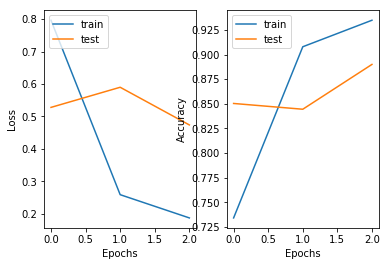

3000/3000 [==============================] - 52s 17ms/step - loss: 0.1875 - acc: 0.9347 - val_loss: 0.4740 - val_acc: 0.8900
Epoch 4/20
3000/3000 [==============================] - 51s 17ms/step - loss: 0.1562 - acc: 0.9463 - val_loss: 0.5424 - val_acc: 0.8788
Epoch 5/20
3000/3000 [==============================] - 51s 17ms/step - loss: 0.1378 - acc: 0.9528 - val_loss: 0.5849 - val_acc: 0.8785
Epoch 6/20
2999/3000 [============================>.] - ETA: 0s - loss: 0.1254 - acc: 0.9571

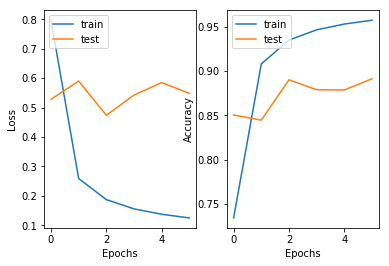

3000/3000 [==============================] - 51s 17ms/step - loss: 0.1254 - acc: 0.9571 - val_loss: 0.5482 - val_acc: 0.8911
Test loss: 0.501405810979
Test accuracy: 0.9323


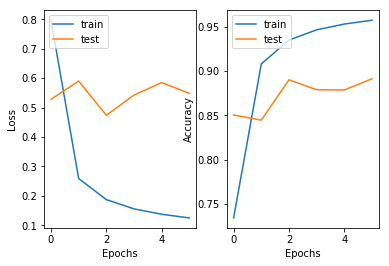

In [7]:
# The final model I ended up with
def random2_model():
    model = Sequential()
    # First convolutional layer with max pooling
    model.add(Conv2D(64, (5, 5), padding="valid", input_shape=input_shape, activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    model.add(Dropout(0.2))

    # Second convolutional layer with max pooling
    model.add(Conv2D(64, (5, 5), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
#     # Third convolutional layer with max pooling
#     model.add(Conv2D(32, (5, 5), padding="valid", activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation="relu"))

    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation="softmax"))

    # Ask Keras to build the TensorFlow model behind the scenes
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])
    return model

# expected loss if just guessing: -ln(1/26)=3.26
batch_size = 32
epochs = 20
steps_per_epoch = 60000 // epochs

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = AccuracyHistory()
checkpointer = ModelCheckpoint(filepath='model.best_2.hdf5',
                               verbose=0, save_best_only=True)

model = random2_model()
# model.load_weights('model.vary_noise_4.hdf5')
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=[0.9,1.1],
    shear_range=0.01,
    width_shift_range=0.01,
    height_shift_range=0.01,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest")


model.fit_generator(aug.flow(x_train,y_train,batch_size=batch_size, shuffle=True),
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          verbose=1,
          validation_data=aug.flow(x_test,y_test,batch_size=batch_size, shuffle=True),
          callbacks=[history,checkpointer,early_stopping])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt_info(history.data)

In [ ]:
# Testing out the model on fresh data

# # inv_key = dict(zip(key_test.values(), key_test.keys()))
# count = 0
# for letter,images in data.items():
#     x = [cv2.resize(im,(img_x,img_y),interpolation=cv2.INTER_AREA) for im in images]
#     x = np.asarray(x)
#     x = x.reshape(x.shape[0], img_x, img_y, 1)
#     prediction = model.predict(x, batch_size=None, verbose=0, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False)
#     for p in np.argmax(prediction,axis=1):
# #         count=count+1
#         if inv_key[p]==letter:
#             count=count+1
# print(count)
# model.load_weights('model.best_1.hdf5')

# data2,labels2 = load_data('data_combined_origsize.npz')
# data, labels = load_data('data_combined_origsize_validation.npz')

x_valid, y_valid =create_dataset(data,175,img_x,img_y,labels,False)
x_valid = x_valid.reshape(x_valid.shape[0], img_x, img_y, 1)

# x_valid,y_valid = x_test,np.argmax(y_test,axis=1)
# convert the data to the right type
x_valid = x_valid.astype('float32')
x_valid /= 255

target_names = labels.keys()

#Confution Matrix and Classification Report
Y_pred = model.predict(x_valid)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
plt.imshow(confusion_matrix(y_valid, y_pred),cmap=plt.cm.Blues)
# plt.xticks(range(0,len(target_names)),target_names)
# plt.yticks(range(0,len(target_names)),target_names)
plt.show()
print('Classification Report')

print(classification_report(y_valid, y_pred, target_names=target_names))